### Initializing the libraries

In [31]:
from sklearn.metrics import *
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor #, export_graphviz #to use graphviz

#uncomment it if you want to use graphviz
#from graphviz import Source 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


import numpy as np
import random as rn
import scipy as sp

### Example synthetic data sets

* syn1 - syn3 : Synthetic 2D binary classification problems
* spiral : Consists of two 2-D spirals, one for each class.

Remember to set the random seed when generating the datasets, if you want reproducible output.

In [7]:
def syn1(N):
    """ data(samples, features)"""
    data = np.empty(shape=(N,2), dtype = np.float32)  
    tar = np.empty(shape=(N,), dtype = np.float32) 
    N1 = int(N/2)
  
    data[:N1,0] = 4 + np.random.normal(loc=.0, scale=1., size=(N1))
    data[N1:,0] = -4 + np.random.normal(loc=.0, scale=1., size=(N-N1))
    data[:,1] = 10*np.random.normal(loc=.0, scale=1., size=(N))
    
    
    data = data / data.std(axis=0)
    
    # Target
    tar[:N1] = np.ones(shape=(N1,))
    tar[N1:] = np.zeros(shape=(N-N1,))
    
    # Rotation
    theta = np.radians(30)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array([[c,-s],[s,c]]) # rotation matrix
    data = np.dot(data,R) 
    
    return data,tar


def syn2(N):
    """ data(samples, features)"""
    data = np.empty(shape=(N,2), dtype = np.float32)  
    tar = np.empty(shape=(N,), dtype = np.float32) 
    N1 = int(N/2)

    # Positive samples
    data[:N1,:] = 0.8 + np.random.normal(loc=.0, scale=1., size=(N1,2))
    # Negative samples 
    data[N1:,:] = -.8 + np.random.normal(loc=.0, scale=1., size=(N-N1,2))
    
    
    # Target
    tar[:N1] = np.ones(shape=(N1,))
    tar[N1:] = np.zeros(shape=(N-N1,))

    return data,tar


def syn3(N):
    """ data(samples, features)"""
    data = np.empty(shape=(N,2), dtype = np.float32)  
    tar = np.empty(shape=(N,), dtype = np.float32) 
    N1 = int(2*N/3)
    
    # disk
    teta_d = np.random.uniform(0, 2*np.pi, N1)
    inner, outer = 2, 5
    r2 = np.sqrt(np.random.uniform(inner**2, outer**2, N1))
    data[:N1,0],data[:N1,1] = r2*np.cos(teta_d), r2*np.sin(teta_d)
        
    #circle
    teta_c = np.random.uniform(0, 2*np.pi, N-N1)
    inner, outer = 0, 3
    r2 = np.sqrt(np.random.uniform(inner**2, outer**2, N-N1))
    data[N1:,0],data[N1:,1] = r2*np.cos(teta_c), r2*np.sin(teta_c)
    

    tar[:N1] = np.ones(shape=(N1,))
    tar[N1:] = np.zeros(shape=(N-N1,))
    
    return data, tar

def spirals(n_points, noise=.5):
    """
     Returns the two spirals dataset.
    """
    nturn = 3
    n = np.sqrt(np.random.rand(n_points,1)) * nturn * (2*np.pi)
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))


### Visualizing data

Here we generate some 100 data samples and visualize them.

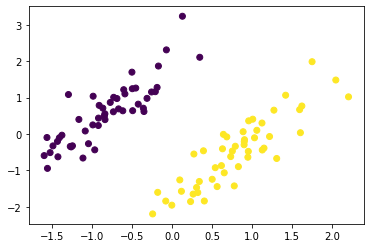

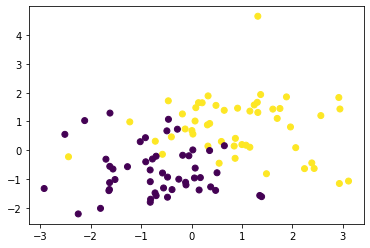

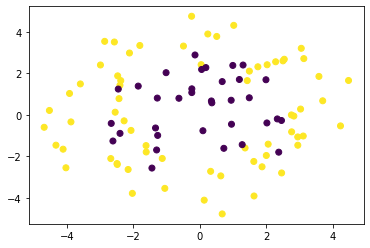

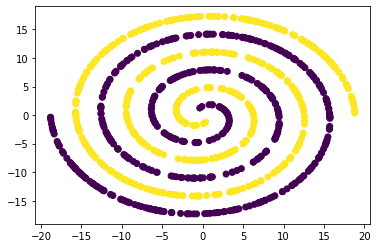

In [33]:
# seed = 0 means random, seed > 0 means fixed
seed = 42
np.random.seed(seed) if seed else None

d,t = syn1(100)
plt.figure(1)
plt.scatter(d[:,0],d[:,1], c=t)

d,t = syn2(100)
plt.figure(2)
plt.scatter(d[:,0],d[:,1], c=t)

d,t = syn3(100)
plt.figure(3)
plt.scatter(d[:,0],d[:,1], c=t)

d,t = spirals(500, 0)
plt.figure(4)
plt.scatter(d[:,0],d[:,1], c=t)
plt.show()

### Plot decision boundaries / regression predictions
Here we defined some functions that can be useful to visualize decision boundaries (for classification) or prediction lines (for regression). 

In [34]:
# The following 2 functions are from the notebooks from Hands-on Machine Learning by A. Geron 
def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

def plot_regression_predictions(tree_reg, X, y, axes=[-50, 50, -1000, 3500], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

# small function to get axes min and max values from a 2D dataset
def get_min_max(x):
    min1, max1 = x[:, 0].min() - .5, x[:, 0].max() + .5
    min2, max2 = x[:, 1].min() - .5, x[:, 1].max() + .5
    return [min1,max1,min2,max2]

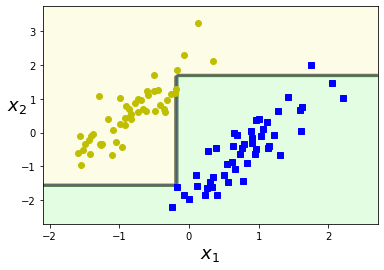

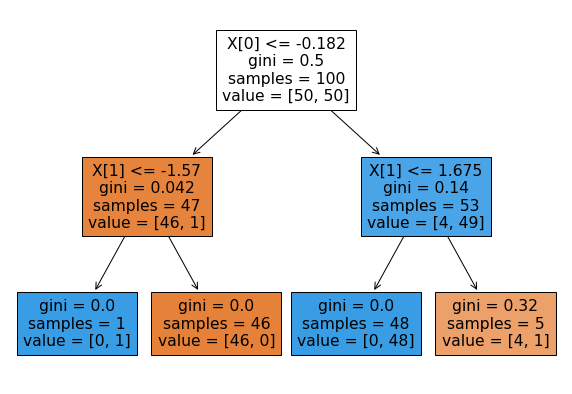

In [35]:
# seed = 0 means random, seed > 0 means fixed
seed = 42
np.random.seed(seed) if seed else None
    
# Generate training data
x_train, d_train = syn1(100)

# Train a decision Tree
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=seed)
tree_clf.fit(x_train, d_train)

# Show the decision boundary
plot_decision_boundary(tree_clf, x_train, d_train, axes=get_min_max(x_train), iris=False)

# Show the tree structure 
fig = plt.figure(figsize=(10,7))
_ = tree.plot_tree(tree_clf, 
                   filled=True)

accuracy score:  0.99


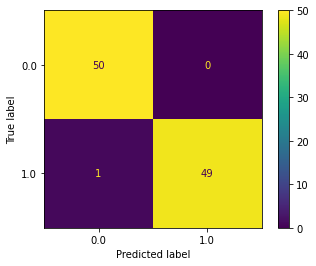

In [36]:
# Look at performance (here measured on the training set itself)
plot_confusion_matrix(tree_clf, x_train, d_train)
print ("accuracy score: ",accuracy_score(d_train, tree_clf.predict(x_train)))

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=57cb3e8b-763a-4858-97a0-0232b8facded' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>